In [ ]:
!pip install textblob
!pip install textblob_fr
!pip install transformers

In [ ]:
!pip install sentencepiece

In [ ]:
# To read csv file from Drive
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

In [3]:
import pandas as pd 
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
import string
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())
import plotly.express as px
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange
import json
import time
import torch
import datetime
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from torch.utils.data import TensorDataset, random_split, \
                            DataLoader, RandomSampler, SequentialSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, \
                         AdamW, get_linear_schedule_with_warmup

# Choose the dataframe for train

In [4]:
from google.colab import files
uploaded = files.upload()

Saving beauty_wellbeing.csv to beauty_wellbeing.csv


In [ ]:
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

In [ ]:
#https://drive.google.com/file/d/ID/view?usp=sharing
# fileDownload = drive.CreateFile({'id':'ID'})
# fileDownload.GetContentFile('beauty_wellbeing.csv')


In [5]:
df = pd.read_csv('/content/beauty_wellbeing.csv')

In [6]:
print('length of dataframe: ', len(df))

length of dataframe:  12672


In [7]:
df.dropna(inplace=True)

In [8]:
print('length of dataframe after drop nan: ', len(df))

length of dataframe after drop nan:  10872


In [9]:
df.columns

Index(['title', 'comments', 'stars', 'time'], dtype='object')

In [10]:
df.drop(['title', 'stars', 'time'], axis=1, inplace=True)

In [11]:
df.head(5)

,comments
0,produit livraison rapide échantillon commande ...
1,envoi rapide excellent produir petit offrir éc...
2,super envoi aime dechantillon produit masculin...
3,command parvenir rapidement échantillon satisf...
4,content achat livraison commande cadeau danniv...


In [12]:
AComment=[]
for comment in df['comments'].apply(str):
    mots = []
    for word in  re.sub("\W"," ",comment ).split():
        mots.append(word)
    AComment.append(mots)

In [13]:
df['mots'] = AComment

In [14]:
df.head(5)

,comments,mots
0,produit livraison rapide échantillon commande ...,"[produit, livraison, rapide, échantillon, comm..."
1,envoi rapide excellent produir petit offrir éc...,"[envoi, rapide, excellent, produir, petit, off..."
2,super envoi aime dechantillon produit masculin...,"[super, envoi, aime, dechantillon, produit, ma..."
3,command parvenir rapidement échantillon satisf...,"[command, parvenir, rapidement, échantillon, s..."
4,content achat livraison commande cadeau danniv...,"[content, achat, livraison, commande, cadeau, ..."


In [15]:
stop_words=set(STOP_WORDS)

# deselect_stop_words = ['n\'','plus','personne','aucun','ni','aucune','rien']
# for w in deselect_stop_words:
#     if w in stop_words:
#         stop_words.remove(w)
#     else:
#         continue

In [16]:
AllfilteredComment=[]
for comment in df['mots']:
    filteredComment = [w for w in comment if not ((w in stop_words) or (len(w) == 1))]
    AllfilteredComment.append(' '.join(filteredComment))

In [17]:
df['motsFiltrer'] = AllfilteredComment

In [18]:
df.head(5)

,comments,mots,motsFiltrer
0,produit livraison rapide échantillon commande ...,"[produit, livraison, rapide, échantillon, comm...",produit livraison rapide échantillon commande
1,envoi rapide excellent produir petit offrir éc...,"[envoi, rapide, excellent, produir, petit, off...",envoi rapide excellent produir petit offrir éc...
2,super envoi aime dechantillon produit masculin...,"[super, envoi, aime, dechantillon, produit, ma...",super envoi aime dechantillon produit masculin...
3,command parvenir rapidement échantillon satisf...,"[command, parvenir, rapidement, échantillon, s...",command parvenir rapidement échantillon satisf...
4,content achat livraison commande cadeau danniv...,"[content, achat, livraison, commande, cadeau, ...",content achat livraison commande cadeau danniv...


In [19]:
senti_list = []
for i in df['motsFiltrer']:
    vs = tb(i).sentiment[0]
    if (vs > 0):
        senti_list.append('Positive')
    elif (vs < 0):
        senti_list.append('Negative')
    else:
        senti_list.append('Neutral') 

In [20]:
df['sentiment'] = senti_list

In [21]:
df.head(5)

,comments,mots,motsFiltrer,sentiment
0,produit livraison rapide échantillon commande ...,"[produit, livraison, rapide, échantillon, comm...",produit livraison rapide échantillon commande,Positive
1,envoi rapide excellent produir petit offrir éc...,"[envoi, rapide, excellent, produir, petit, off...",envoi rapide excellent produir petit offrir éc...,Positive
2,super envoi aime dechantillon produit masculin...,"[super, envoi, aime, dechantillon, produit, ma...",super envoi aime dechantillon produit masculin...,Positive
3,command parvenir rapidement échantillon satisf...,"[command, parvenir, rapidement, échantillon, s...",command parvenir rapidement échantillon satisf...,Positive
4,content achat livraison commande cadeau danniv...,"[content, achat, livraison, commande, cadeau, ...",content achat livraison commande cadeau danniv...,Positive


In [22]:
fig = px.histogram(df, x="sentiment",color="sentiment", width=1000)
fig.update_layout(
    title_text='Sentiment of reviews', # title of plot
    xaxis_title_text='Sentiment', # xaxis label
    yaxis_title_text='Count', # yaxis label
    bargap=0.2, 
    bargroupgap=0.1
)
fig.show()

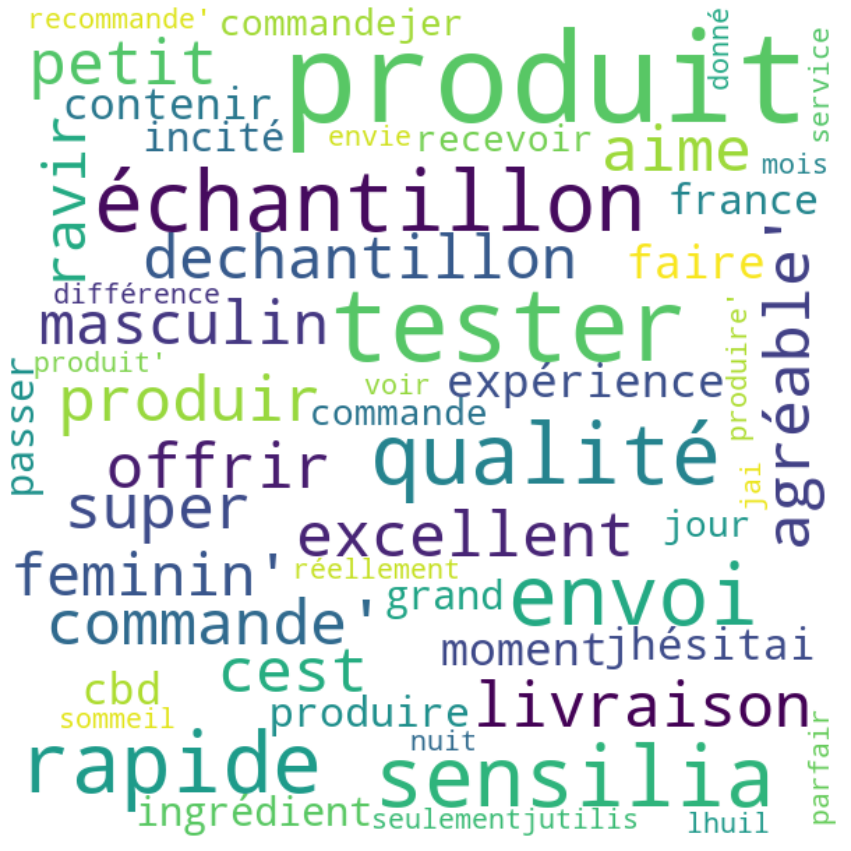

In [23]:
text = str(df['motsFiltrer'].values)
def plot_word_cloud(text) :
    
    # Définir le calque du nuage des mots
    wc = WordCloud(width=600,height=600,background_color="white", max_words=100, stopwords=stop_words, max_font_size=90,collocations = False, random_state=42)

    # Générer et afficher le nuage de mots
    plt.figure(figsize= (15,20))
    wc.generate(text)
    plt.imshow(wc,interpolation="bilinear")
    plt.axis("off")
    plt.show()
plot_word_cloud(text)

In [24]:
df['sentiment'] = df['sentiment'].replace('Positive',1)
df['sentiment'] = df['sentiment'].replace('Neutral',2)
df['sentiment'] = df['sentiment'].replace('Negative',0)

In [25]:
df.head(5)

,comments,mots,motsFiltrer,sentiment
0,produit livraison rapide échantillon commande ...,"[produit, livraison, rapide, échantillon, comm...",produit livraison rapide échantillon commande,1
1,envoi rapide excellent produir petit offrir éc...,"[envoi, rapide, excellent, produir, petit, off...",envoi rapide excellent produir petit offrir éc...,1
2,super envoi aime dechantillon produit masculin...,"[super, envoi, aime, dechantillon, produit, ma...",super envoi aime dechantillon produit masculin...,1
3,command parvenir rapidement échantillon satisf...,"[command, parvenir, rapidement, échantillon, s...",command parvenir rapidement échantillon satisf...,1
4,content achat livraison commande cadeau danniv...,"[content, achat, livraison, commande, cadeau, ...",content achat livraison commande cadeau danniv...,1


In [26]:
df.drop( df[ df['sentiment'] == 2 ].index, inplace=True)

In [27]:
# Defining constants
epochs = 5
MAX_LEN = 128
batch_size = 1
device = torch.device('cuda')

In [28]:
# Initialize CamemBERT tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base',do_lower_case=True)

In [29]:
# Creates list of texts and labels
text = df['comments'].to_list()
labels = df['sentiment'].to_list()

#user tokenizer to convert sentences into tokenizer
input_ids  = [tokenizer.encode(sent,add_special_tokens=True,truncation=True,max_length=MAX_LEN) for sent in text]

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks
# attention_masks = []
# # Create a mask of 1s for each token followed by 0s for padding
# for seq in input_ids:
#     seq_mask = [float(i>0) for i in seq]  
#     attention_masks.append(seq_mask)

In [30]:
input_ids

array([[    5,   501,  1769, ...,     0,     0,     0],
       [    5, 12862,   924, ...,     0,     0,     0],
       [    5,   860, 12862, ...,     0,     0,     0],
       ...,
       [    5,   501,   335, ...,     0,     0,     0],
       [    5,  3019,   501, ...,     0,     0,     0],
       [    5,   501,   366, ...,     0,     0,     0]])

In [31]:
df_SMOTE = pd.DataFrame(data=input_ids)


In [32]:
df_SMOTE['labels'] = labels

In [33]:
df_SMOTE.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,labels
0,5,501,1769,924,15735,1063,355,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,5,12862,924,2183,909,830,764,226,1880,15735,60,41,1368,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,5,860,12862,1473,8,2878,3394,501,6567,4152,1407,236,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,5,22490,4784,736,15735,6639,3480,13157,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,5,2945,2753,1769,1063,2275,18,20107,4059,633,1653,19401,227,501,1611,3139,2446,341,15735,132,1883,3953,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [34]:
X = df_SMOTE.drop('labels', axis=1)
y = df_SMOTE['labels']

# Model with SMOTE

In [35]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

x_sm, y_sm = oversample.fit_resample(X, y)


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [36]:
y_sm = y_sm.tolist()


In [37]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in x_sm:
    seq_mask = [float(i>0) for i in seq]  
    attention_masks.append(seq_mask)

In [41]:

print(f'''Shape of X before SMOTE: {input_ids.shape}
Shape of X after SMOTE: {x_sm.shape}''')

Shape of X before SMOTE: (9126, 128)
Shape of X after SMOTE: (16786, 128)


In [42]:
# Use train_test_split to split our data into train and validation sets for training
train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(x_sm, y_sm, attention_masks,
                                                            random_state=42, test_size=0.1)


# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [ ]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 
model = CamembertForSequenceClassification.from_pretrained("camembert-base", num_labels=2)
model.to(device)

In [44]:
type(model)

transformers.models.camembert.modeling_camembert.CamembertForSequenceClassification

In [45]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5, eps=10e-8)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [46]:
# Store our loss and accuracy for plotting if we want to visualize training evolution per epochs after the training process
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
    # Tracking variables for training
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  
    # Train the model
    model.train()
    for step, batch in enumerate(train_dataloader):
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        # Get loss value
        loss = outputs[0]
        # Add it to train loss list
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()
    
        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    


    # Tracking variables for validation
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    # Validation of the model
    model.eval()
    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to device CPU or GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            outputs =  model(b_input_ids,token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss, logits = outputs[:2]
    
        # Move logits and labels to CPU if GPU is used
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))



Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.33642820238251714


Epoch:  20%|██        | 1/5 [16:41<1:06:46, 1001.62s/it]

Validation Accuracy: 0.5473496128648004
Train loss: 0.6832532078094798


Epoch:  40%|████      | 2/5 [33:24<50:06, 1002.00s/it]  

Validation Accuracy: 0.4973198332340679
Train loss: 0.6709303614678086


Epoch:  60%|██████    | 3/5 [50:00<33:20, 1000.25s/it]

Validation Accuracy: 0.4973198332340679
Train loss: 0.5815520962536448


Epoch:  80%|████████  | 4/5 [1:06:39<16:39, 999.86s/it]

Validation Accuracy: 0.8558665872543181
Train loss: 0.16993447593866873


Epoch: 100%|██████████| 5/5 [1:23:20<00:00, 1000.03s/it]

Validation Accuracy: 0.9642644431209053


In [47]:
print("Model saved!")
torch.save(model.state_dict(), "/content/sentiments_pytorch.pt")

Model saved!


In [48]:
model.load_state_dict(torch.load('/content/sentiments_pytorch.pt'))


<All keys matched successfully>

In [1]:
import pandas as pd

In [294]:
df_category = pd.read_csv('/content/beauty_wellbeing.csv')

In [295]:
df_category.head(5)

,title,comments,stars,time
0,\n Bon produit\n ...,produit livraison rapide échantillon commande ...,5 étoiles : excellent,2021-06-19T05:05:28+00:00
1,\n Envoi très rapide\n ...,envoi rapide excellent produir petit offrir éc...,5 étoiles : excellent,2021-06-18T14:03:47+00:00
2,\n super envoi- on aura...,super envoi aime dechantillon produit masculin...,5 étoiles : excellent,2021-06-17T23:14:19+00:00
3,\n Commande parvenue ra...,command parvenir rapidement échantillon satisf...,5 étoiles : excellent,2021-06-17T17:54:31+00:00
4,\n Site sérieux je reco...,content achat livraison commande cadeau danniv...,5 étoiles : excellent,2021-06-17T16:02:08+00:00


In [296]:
len(df_category)

12672

In [297]:
df_category.dropna(inplace=True)

In [298]:
len(df_category)

10872

In [299]:
df_category['avis'] = df_category['title'].str.strip() + df_category['comments']

In [300]:
df_category = df_category.sample(frac =.005) 

In [301]:
len(df_category)

54

In [302]:
df_category.head(5)

,title,comments,stars,time,avis
8267,\n Un excellent produit...,excellent produit venir dutiliser relaxer sens...,5 étoiles : excellent,2021-03-22T13:09:09+00:00,Un excellent produit que je viens…excellent pr...
2387,\n Très bien\n ...,livraison rapide ultrer content commande,5 étoiles : excellent,2021-02-16T21:27:08+00:00,Très bienlivraison rapide ultrer content commande
9599,\n Super\n,super livrer lendemain command produit dexcell...,5 étoiles : excellent,2021-06-03T18:45:04+00:00,Supersuper livrer lendemain command produit de...
12473,\n 6 semaines : 6 kgs\n...,semaine kilosj ajoute légume vert plat varier ...,5 étoiles : excellent,2021-05-06T16:27:52+00:00,6 semaines : 6 kgssemaine kilosj ajoute légume...
12619,\n Superbe qualité et u...,superbe qualité service commercial top recomma...,5 étoiles : excellent,2021-05-27T13:39:46+00:00,Superbe qualité et un service…superbe qualité ...


In [303]:

df_category.drop(['title', 'comments', 'stars', 'time'], axis=1, inplace=True)

In [304]:
comments = df_category['avis'].reset_index(drop=True)

In [305]:
comments

0     Un excellent produit que je viens…excellent pr...
1     Très bienlivraison rapide ultrer content commande
2     Supersuper livrer lendemain command produit de...
3     6 semaines : 6 kgssemaine kilosj ajoute légume...
4     Superbe qualité et un service…superbe qualité ...
5     Jolies cuissardesbel confortable seul bémol vo...
6     deja 1 ans que je commande sur se sitedejer an...
7     Je recommandelivraison rapide produire emballe...
8            Rapide et conformearapide conforme parfair
9     1ère commande chez Graine de Pastelère command...
10    TOP ! Cet aspirateur correspond à la…aspirateu...
11    Mention spéciale pour le service client…mentio...
12    Produit conforme à mes attentesproduit conform...
13    Livraison rapide et discrètelivraison rapide d...
14    Parfaitparfair store occulter qualité livraiso...
15    Agréablecolis recevoir rapidement savon charbo...
16    Site simple et clair avec beaucoup de…site sim...
17    Commande conformecommand conforme délai li

In [306]:
# Encode the comments
tokenized_comments_ids = [tokenizer.encode(comment,add_special_tokens=True,max_length=MAX_LEN) for comment in comments]
# Pad the resulted encoded comments
tokenized_comments_ids = pad_sequences(tokenized_comments_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Create attention masks 
attention_masks = []
for seq in tokenized_comments_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

prediction_inputs = torch.tensor(tokenized_comments_ids)
prediction_masks = torch.tensor(attention_masks)

In [307]:
# Apply the finetuned model (Camembert)
flat_pred = []
with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs =  model(prediction_inputs.to(device),token_type_ids=None, attention_mask=prediction_masks.to(device))
    logits = outputs[0]
    logits = logits.detach().cpu().numpy() 
    flat_pred.extend(np.argmax(logits, axis=1).flatten())

In [308]:
print(flat_pred)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [309]:
for i in range(len(flat_pred)):
    print('Label', flat_pred[i], '-->', comments[i])
    # print('Comment: ', comments[i])
    # print('Label', flat_pred[i])
    print('**************************')

Label 1 --> Un excellent produit que je viens…excellent produit venir dutiliser relaxer sensation immédiat bcp clariss permettre renouer pratique ancestral
**************************
Label 1 --> Très bienlivraison rapide ultrer content commande
**************************
Label 1 --> Supersuper livrer lendemain command produit dexcellent rapport qualitéprix dmannose commande vitaminexpre
**************************
Label 1 --> 6 semaines : 6 kgssemaine kilosj ajoute légume vert plat varier jaime simple appel substitue lon aim naimerionsvper facilement approprier méthode grâce magazine détailler fort intéressant livret clair concis marche minute heure jour vite jécoute corpshonnêtement suivi sérieux conseiller nutritionnister répondre concrètement besoin question courtoisie professionnalismesuivre programme gage réussite poursuivre jusquau poids forme corps
**************************
Label 1 --> Superbe qualité et un service…superbe qualité service commercial top recommander vivement
****